## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification, EarlyStoppingCallback
from transformers import Trainer, TrainingArguments

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Load synthetic data
df1 = pd.read_csv("/content/synthetic-sentiment-1.csv")
df2 = pd.read_csv("/content/synthetic-sentiment-2.csv")
df3 = pd.read_csv("/content/synthetic-sentiment-3.csv")
df4 = pd.read_csv("/content/synthetic-sentiment-4.csv")
df5 = pd.read_csv("/content/synthetic-sentiment-5.csv")
df6 = pd.read_csv("/content/synthetic-sentiment-6.csv")

# Load additional hard examples
hard_train = pd.read_csv("/content/hard_train.csv")
hard_test = pd.read_csv("/content/hard_test.csv")

synthetic_data = pd.concat([df1, df2, df3, df4, df5, df6], axis=0).reset_index(drop=True)
print(synthetic_data.info())
synthetic_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39900 entries, 0 to 39899
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  39900 non-null  object
 1   stance     39900 non-null  object
dtypes: object(2)
memory usage: 623.6+ KB
None


,utterance,stance
0,I really admire the way you handled that situa...,positive
1,Why are you always so negative about everything?,negative
2,Did you manage to finish the report on time?,neutral
3,I can't believe you forgot our anniversary again.,negative
4,Thanks for listening to me vent earlier.,positive


In [3]:
# Find non-unique utterances
utterance_counts = pd.DataFrame(synthetic_data["utterance"].value_counts()).reset_index()
utterance_counts[utterance_counts["count"] > 1]

,utterance,count
0,I can't believe you forgot my birthday again.,141
1,I can't believe you forgot again.,95
2,"Could you pass me the salt, please?",85
3,You never listen to what I'm saying.,85
4,You never listen to what I have to say.,63
...,...,...
2946,I don't have time for this right now.,2
2947,I can't believe you forgot to pick me up.,2
2948,Are we still on for lunch tomorrow?,2
2949,Do you know where the keys are?,2


In [4]:
# Drop duplicate entries
synthetic_data = synthetic_data.drop_duplicates().reset_index(drop=True)
synthetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31122 entries, 0 to 31121
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  31122 non-null  object
 1   stance     31122 non-null  object
dtypes: object(2)
memory usage: 486.4+ KB


,count
stance,
neutral,12451
positive,10066
negative,8605


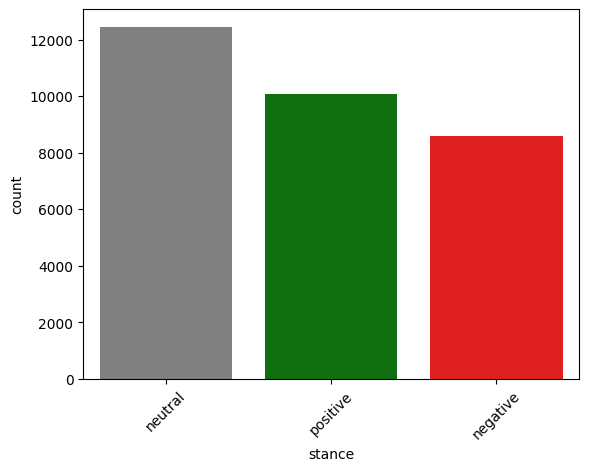

neutral: 0.400%
positive: 0.323%
negative: 0.276%


In [5]:
# Show stance counts and plot
display(synthetic_data["stance"].value_counts())

ax = sns.barplot(
    data=synthetic_data["stance"].value_counts().reset_index(),
    x='stance',
    y='count',
    hue='stance',
    palette={"positive": "green", "neutral": "gray", "negative": "red"}
)

plt.xticks(rotation=45)
plt.show()

normalized_value_counts = synthetic_data["stance"].value_counts(normalize=True)

for label, freq in normalized_value_counts.items():
    print(f"{label}: {freq:.3f}%")

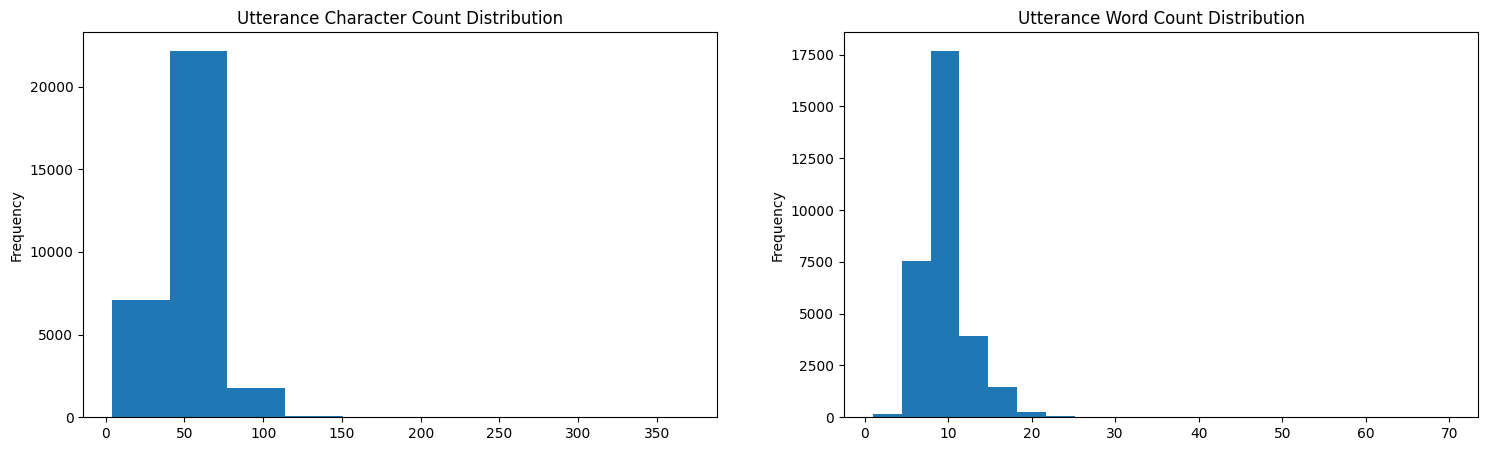

In [6]:
# Plot distribution of character and word counts
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

synthetic_data["utterance"].apply(len).plot(kind='hist', ax=axs[0], title="Utterance Character Count Distribution")

synthetic_data["utterance"].str.split().apply(len).plot(kind='hist', bins=20, ax=axs[1], title="Utterance Word Count Distribution")

plt.show()

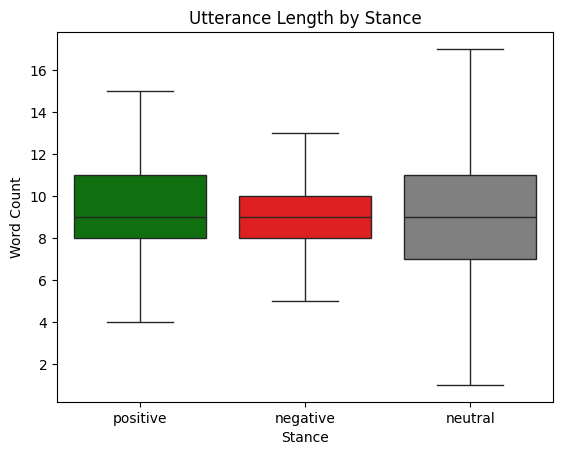

In [7]:
# Plot utterance length distribution, grouped by stance
sns.boxplot(
    x=synthetic_data["stance"],
    y=synthetic_data["utterance"].str.split().str.len(),
    showcaps=True,
    hue="stance",
    palette={"positive": "green", "neutral": "gray", "negative": "red"},
    showfliers=False,
    data=synthetic_data
)

plt.xlabel("Stance")
plt.ylabel("Word Count")
plt.title("Utterance Length by Stance")
plt.show()

In [8]:
# Take sample of each stance class
print("Sample of positive examples:\n")
pos_sample = synthetic_data[synthetic_data["stance"] == "positive"]["utterance"].sample(n=5).values
for sample in pos_sample:
  print(sample)
print("\n")

print("Sample of neutral examples:\n")
neu_sample = synthetic_data[synthetic_data["stance"] == "neutral"]["utterance"].sample(n=5).values
for sample in neu_sample:
  print(sample)
print("\n")

print("Sample of negative examples:\n")
neg_sample = synthetic_data[synthetic_data["stance"] == "negative"]["utterance"].sample(n=5).values
for sample in neg_sample:
  print(sample)
print("\n")

Sample of positive examples:

This cake you made tastes incredible.
Thanks for always being someone I can rely on.
I'm really sorry I can't help you with this.
That's a pretty good idea you came up with.
I can't believe how good you are at chess!


Sample of neutral examples:

Why did you choose to go with that outfit today? It's not typically your style.
Can you believe they close at 6 p.m.?
It’s going to rain tomorrow, according to the forecast.
Did you get a chance to watch that documentary?
Is there any update on the report I asked you about?


Sample of negative examples:

You never listen to what I really want.
I really don't care what you think about my unicorn collection.
I can't find my keys, and you had them last!
Your room is a complete mess right now.
Why do I need to explain myself to you every single time? I don't think you even listen half the time, it's incredibly frustrating and I really wish you'd just try a little harder because this conversation feels like it never 

# Training the model

In [9]:
# Set up label mappings
id2label = {
    0: "neutral",
    1: "positive",
    2: "negative"
}

label2id = {
    "neutral": 0,
    "positive": 1,
    "negative": 2
}


In [10]:
# Download tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
# Split dataset
train_df, test_df = train_test_split(
    synthetic_data,
    test_size=0.1,
    random_state=42
)

# Add hard examples and shuffle
train_df = pd.concat([train_df, hard_train], ignore_index=True)
train_df = train_df.sample(frac=1, random_state=42)
test_df = pd.concat([test_df, hard_test], ignore_index=True)
test_df = test_df.sample(frac=1, random_state=42)

# Split into x and y
train_inputs = train_df["utterance"]
train_labels = train_df["stance"]
test_inputs = test_df["utterance"]
test_labels = test_df["stance"]

print(train_inputs.info())
print(test_inputs.info())

# Encode the train and val labels
train_encoded = tokenizer(list(train_inputs), padding=True, truncation=True, return_tensors="pt")
test_encoded = tokenizer(list(test_inputs), padding=True, truncation=True, return_tensors="pt")
train_label_ids = [label2id[s] for s in train_labels]
test_label_ids = [label2id[s] for s in test_labels]

<class 'pandas.core.series.Series'>
Index: 28363 entries, 27781 to 23654
Series name: utterance
Non-Null Count  Dtype 
--------------  ----- 
28363 non-null  object
dtypes: object(1)
memory usage: 443.2+ KB
None
<class 'pandas.core.series.Series'>
Index: 3153 entries, 3143 to 860
Series name: utterance
Non-Null Count  Dtype 
--------------  ----- 
3153 non-null   object
dtypes: object(1)
memory usage: 49.3+ KB
None


In [41]:
# Create torch dataset
class SentimentDataset(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    item = {k: v[idx] for k, v in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item

# Creat train and test datasets
train_ds = SentimentDataset(train_encoded, train_label_ids)
test_ds = SentimentDataset(test_encoded, test_label_ids)

In [20]:
# Helper funtion to log additional metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [64]:
# Create model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3, id2label=id2label, label2id=label2id).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
# Configure trainer and train the model
batch_size = 128
training_args = TrainingArguments(
    output_dir="distilbert-directed-sentiment",
    num_train_epochs=20,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    # weight_decay=0.01,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

<ipython-input-65-ebe4e57e277f>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.308400,0.169213,0.942277,0.942046
2,0.143300,0.153501,0.949255,0.949361
3,0.102100,0.149273,0.953061,0.953163
4,0.075400,0.158768,0.952426,0.952461
5,0.052500,0.164419,0.955598,0.955599


TrainOutput(global_step=1110, training_loss=0.13633520280992661, metrics={'train_runtime': 226.9901, 'train_samples_per_second': 2499.051, 'train_steps_per_second': 19.56, 'total_flos': 3082110799624920.0, 'train_loss': 0.13633520280992661, 'epoch': 5.0})

              precision    recall  f1-score   support

     neutral       0.97      0.95      0.96      1303
    positive       0.95      0.97      0.96      1044
    negative       0.92      0.94      0.93       806

    accuracy                           0.95      3153
   macro avg       0.95      0.95      0.95      3153
weighted avg       0.95      0.95      0.95      3153



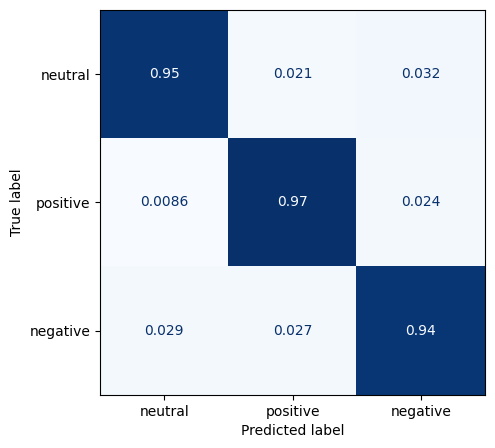

In [66]:
# Generate predictions for test dataset
predictions = trainer.predict(test_ds)
logits = predictions.predictions
y_pred = np.argmax(logits, axis=-1)
y_true = predictions.label_ids

# Evaluate
print(classification_report(y_true, y_pred, target_names=label2id))
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.show()

## Exporting the model

In [ ]:
!pip install onnx onnxruntime onnxruntime-tools

In [69]:
# Save the model and check its size
trainer.save_model("./directed-sentiment-model")
model_path = "/content/directed-sentiment-model/model.safetensors"
size_bytes = os.path.getsize(model_path)
size_megabytes = size_bytes / (1024 * 1024)

print(f"Model size: {size_megabytes:.2f} MB")

Model size: 255.43 MB


In [70]:
# Export model as ONNX
# Move model to CPU first
model.to("cpu").eval()

# Create dummy input tensor for input/output shape
dummy_input = (torch.zeros(1, 512, dtype=torch.long), torch.zeros(1, 512, dtype=torch.long))

torch.onnx.export(
  model,
  dummy_input,
  "/content/directed-sentiment-model.onnx",
  input_names=["input_ids", "attention_mask"],
  output_names=["logits"],
  dynamic_axes={
    # Batch size of 1
    "input_ids": {1: "seq_len"},
    "attention_mask": {1: "seq_len"},
    "logits": {0: "batch_size"}
  },
  opset_version=14
)

In [71]:
# Check that model exported correctly
from torch.utils.data import DataLoader
import onnxruntime as ort

# Create a data loader for the test dataset
test_loader = DataLoader(test_ds, batch_size=1)

# Load ONNX runtime inference session for the model
onnx_model = ort.InferenceSession("/content/directed-sentiment-model.onnx", providers=["CPUExecutionProvider"])

# Run ONNX model on the test set
all_preds = []
all_labels = []
for batch in test_loader:
  input_ids = batch["input_ids"].numpy()
  attn_mask = batch["attention_mask"].numpy()
  labels = batch["labels"].numpy()

  inputs = {
      "input_ids": input_ids,
      "attention_mask": attn_mask,
  }

  outputs = onnx_model.run(None, inputs)
  logits = outputs[0]
  preds = np.argmax(logits, axis=-1)

  all_preds.append(preds)
  all_labels.append(labels)

# Stack everything
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)

# Evaluate
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1303
           1       0.95      0.97      0.96      1044
           2       0.92      0.94      0.93       806

    accuracy                           0.95      3153
   macro avg       0.95      0.95      0.95      3153
weighted avg       0.95      0.95      0.95      3153

